TABLE OF CONTENT
1. Import library
2. Dataset
3. Load Data -> Density Map
4. membuat model MCNN
5. persiapan data train | test | validasi
6. proses training
7. proses testing
8. Evaluasi



#**1. IMPORT LIBRARY**

In [ ]:
# Impor pustaka untuk manipulasi data
import pandas as pd  # untuk manipulasi dan analisis data
import numpy as np   # untuk operasi array dan komputasi numerik

# Impor pustaka untuk visualisasi data
import matplotlib.pyplot as plt  # untuk membuat visualisasi grafis

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
import seaborn as sns

# Impor pustaka untuk pengolahan jalur file
import os   # untuk berinteraksi dengan sistem operasi
from pathlib import Path  # untuk bekerja dengan jalur file dan direktori
import glob  # untuk mencocokkan pola dengan nama file atau jalur
from PIL import Image

# Impor pustaka untuk memuat data MATLAB
from scipy.io import loadmat  # untuk memuat file MATLAB (.mat)

import random # menghasilkan angka acak atau operasi acak

# Impor pustaka untuk pengolahan gambar
import cv2   # untuk pengolahan gambar
from scipy.ndimage import gaussian_filter  # untuk menerapkan filter Gaussian

from torchvision import transforms

# Impor pustaka untuk deep learning
import torch   # untuk komputasi tensor
import torch.nn as nn   # untuk membangun dan melatih jaringan saraf
import torch.optim as optim   # untuk algoritma optimasi
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader   # untuk bekerja dengan dataset dan data loader
import torchvision   # alat dan dataset untuk visi komputer dengan PyTorch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**2. DATASET**

Menampilkan contoh data

## **RESIZE DATA PRIMER**

In [ ]:
# Fungsi untuk resize gambar dan mengubah nama file
def resize_and_rename_images(input_dir, output_dir, new_size=(610, 610)):
    # Pastikan direktori output ada
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # List semua file di direktori input
    for i, filename in enumerate(os.listdir(input_dir), start=1):
        # Baca gambar
        img_path = os.path.join(input_dir, filename)
        with Image.open(img_path) as img:
            # Resize gambar
            resized_img = img.resize(new_size)

            # Ubah nama file
            new_filename = f'test-{i}.jpg'  # Tambahkan nomor urut
            new_img_path = os.path.join(output_dir, new_filename)

            # Simpan gambar yang sudah diresize
            resized_img.save(new_img_path)

# Contoh pemanggilan fungsi
input_directory = '/content/drive/MyDrive/InformatikaPariwisata/dataset/data primer/test'
output_directory = '/content/drive/MyDrive/InformatikaPariwisata/dataset/data primer/newTest'
new_image_size = (610, 610)  # Ukuran baru untuk resize (lebar, tinggi)

resize_and_rename_images(input_directory, output_directory, new_size=new_image_size)
print('proses selesai')


In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def show_resized_images(output_dir, num_images=10):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for i in range(num_images):
        filename = f'test-{i+1}.jpg'  # Ubah sesuai dengan pola penamaan yang Anda gunakan
        img_path = os.path.join(output_dir, filename)

        # Baca dan tampilkan gambar
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Contoh pemanggilan fungsi untuk menampilkan gambar
output_directory = '/content/drive/MyDrive/InformatikaPariwisata/dataset/data primer/newTest'
show_resized_images(output_directory)


Output hidden; open in https://colab.research.google.com to view.

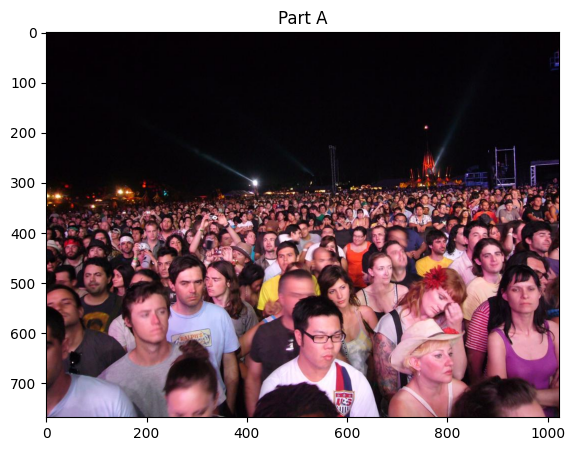

In [ ]:
# Path gambar dan part_A
path_img_ex_A = '/content/drive/MyDrive/InformatikaPariwisata/dataset/ShanghaiTech/part_A/train_data/images/IMG_6.jpg'

# Membaca gambar dan mengubah warna BGR ke RGB
image_ex_A = cv2.cvtColor(cv2.imread(path_img_ex_A), cv2.COLOR_BGR2RGB)

# Menampilkan gambar
figure, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.imshow(image_ex_A)
ax.set_title('Part A')
ax.axis('on')  # atau gunakan ax.axis('off') jika Anda tidak ingin menampilkan sumbu

plt.show()


#### **LOAD GT**
* load GT yang mana berbentuk dictionary berisi nilai posisi X dan Y

* jumlah array menunjukkan jumlah orang dalam gambar

In [ ]:
# Path GT part_A dan part_A
path_gt_ex_A = "/content/drive/MyDrive/InformatikaPariwisata/dataset/ShanghaiTech/part_A/train_data/ground-truth/GT_IMG_6.mat"

# Membaca GT
gt_ex_A = loadmat(path_gt_ex_A)

# Menampilkan hasil
print('type part_A: ', type(gt_ex_A))
print(gt_ex_A.items())


type part_A:  <class 'dict'>
dict_items([('__header__', b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Nov 18 20:06:15 2016'), ('__version__', '1.0'), ('__globals__', []), ('image_info', array([[array([[(array([[   9.00940439,  644.82791619],
                       [  38.27982181,  548.65368751],
                       [ 212.50849695,  558.41049332],
                       ...,
                       [1016.63190893,  316.92954958],
                       [1016.98036628,  297.41593796],
                       [1006.64279822,  309.43771655]]), array([[554]], dtype=uint16))]],
              dtype=[('location', 'O'), ('number', 'O')])                                ]],
      dtype=object))])


In [ ]:
print(gt_ex_A.keys())

dict_keys(['__header__', '__version__', '__globals__', 'image_info'])


In [ ]:
# Mengakses data GT
gt_coor_ex_A = gt_ex_A.get('image_info')[0][0][0][0][0]
print('Shape of coordinates part_A: ', gt_coor_ex_A.shape)

Shape of coordinates part_A:  (554, 2)


Membuat penanda (x) pada gambar dengan mengambil koordinat dari GT

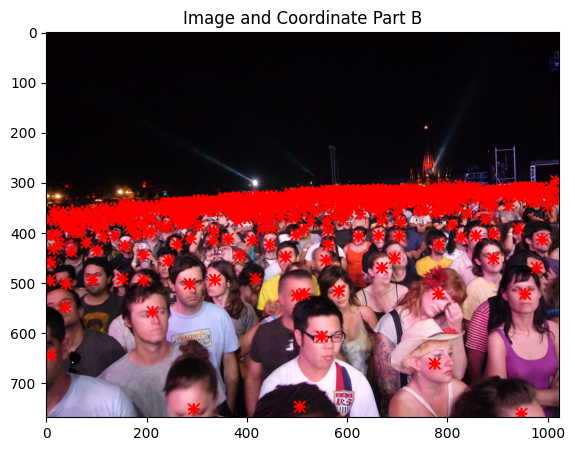

In [ ]:
# Membuat tanda berdasarkan ground truth pada gambar part_A
for x_cor_A, y_cor_A in gt_coor_ex_A:
    cv2.drawMarker(image_ex_A, (int(x_cor_A), int(y_cor_A)), (255, 0, 0), markerType=cv2.MARKER_STAR, thickness=3)

# Menampilkan gambar 1 baris 2 kolom
figure, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.imshow(image_ex_A)
ax.set_title('Image and Coordinate Part B')
ax.axis('on')

plt.show()

#### **FUNGSI gen_density_map_gaussian**



Ekstrak koordinat sebagai density map. Dengan fungsi **gen_density_map_gaussian** dapat divisualisasikan :    


*   koordinat orang
*   jumlah density map adalah jumlah orang pada gambar
*   ukuran density map sama dengan gambar input



---



density map tersebut akan digunakan sebagai 'label' untuk CNN

In [ ]:
def gen_density_map_gaussian(img, points, sigma=15):
    density_map = np.zeros((img.shape[0], img.shape[1]), dtype=np.float32)
    for point in points:
        y, x = min(int(point[1]), img.shape[0] - 1), min(int(point[0]), img.shape[1] - 1)
        density_map[y, x] = 1
    density_map = cv2.GaussianBlur(density_map, (0, 0), sigma)
    return density_map

*note*
* Filter Gaussian digunakan untuk menyebarkan nilai-nilai di sekitar titik-titik yang ada, menciptakan efek redup yang menggambarkan "kepadatan" titik-titik tersebut.
* Sigma digunakan untuk mengontrol seberapa besar efek redup ini
* Parameter truncate = analoginya seperti pembatas pada jendela (kernel gaussian). Semakin besar nilainya, semakin banyak "tetangga" yang diperhitungkan oleh jendela itu, dan sebaliknya


 mengapa menggunakan skema 'jet' = jet dapat menyoroti perbedaan intensitas atau nilai dalam data

max1 :  tensor(1.)
max2 :  0.041571297
min1 :  tensor(0.)
min2 :  0.0


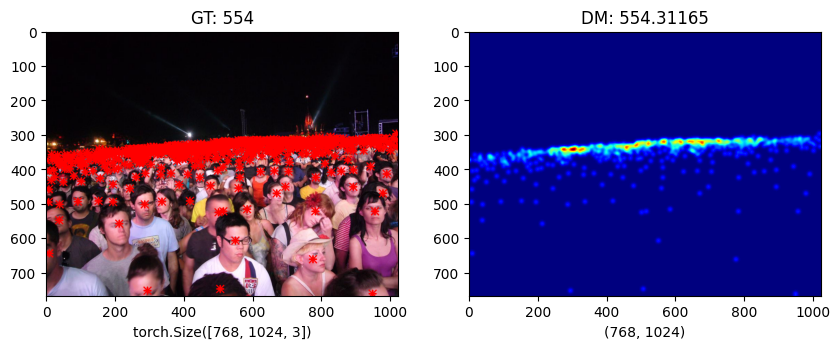

In [ ]:
# Memanggil fungsi gen_density_map_gaussian part_A
density_map_ex_A = gen_density_map_gaussian(image_ex_A, gt_coor_ex_A, 5)

figure = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
# tensor PyTorch dan menormalisasi nilai piksel dari rentang [0, 255] ke [0, 1] dengan membaginya dengan 255.
image_ex_A = torch.tensor(image_ex_A/255, dtype=torch.float)
plt.xlabel(image_ex_A.shape)
plt.title('GT: '+str(gt_coor_ex_A.shape[0]))
plt.imshow(image_ex_A)

plt.subplot(1,2,2)
plt.xlabel(density_map_ex_A.shape)
plt.title('DM: '+str(np.sum(density_map_ex_A)))
plt.imshow(density_map_ex_A, cmap="jet")

print('max1 : ', image_ex_A.max())
print('max2 : ', density_map_ex_A.max())
print('min1 : ', image_ex_A.min())
print('min2 : ', density_map_ex_A.min())

*note*

**image_ex.max() dan image_ex.min():**

*  max1: nilai piksel tertinggi dalam gambar asli yang telah dinormalisasi (mendekati 1 jika gambar memiliki piksel putih setelah normalisasi).
* min1: nilai piksel terendah dalam gambar asli yang telah dinormalisasi (mendekati 0 jika gambar memiliki piksel hitam setelah normalisasi).

**density_map_ex.max() dan density_map_ex.min():**

* max2: nilai tertinggi dalam peta kepadatan. Ini memberi informasi tentang titik dengan kepadatan tertinggi setelah filter Gaussian diterapkan.
* min2: nilai terendah dalam peta kepadatan. Setelah aplikasi filter Gaussian, nilai ini biasanya mendekati 0 tetapi tidak selalu 0 karena efek penyebaran Gaussian.

#**3. LOAD DATA -> DENSITY MAP**

Buat Data Loader, ekstrak kunci 'image_info' di MAT untuk mendapatkan koordinat lokasi orang. Kemudian gunakan **gen_density_map_gaussian** untuk membuat density map setiap gambar. Selain itu, ambil dimensi matriks koordinat sebagai jumlah orang, yang dapat digunakan untuk fungsi kerugian model. Downsample diterapkan agar sesuai dengan bentuk density map pada output model pelatihan.

In [ ]:
class DataLoader(torch.utils.data.Dataset):
    # Menginisialisasi objek dari class DataLoader
    def __init__(self, root_dir, gt_downsample=4, shuffle=False, resize=(256, 256)):
        self.root_dir = root_dir
        self.gt_downsample = gt_downsample
        self.shuffle = shuffle
        self.resize = resize  # Tambahkan parameter ukuran
        self.img_names = [filename for filename in os.listdir(os.path.join(root_dir, 'images')) if filename.endswith('.jpg')]

        # list dengan file images berformat .jpg
        if self.shuffle:
            random.shuffle(self.img_names)

        # Menyimpan jumlah orang yang dideteksi di setiap gambar
        self.n_people = {}
        # Menyimpan DP yang dihasilkan dari setiap gambar
        self.DMs = {}
        # Iterasi setiap nama file gambar
        for image_filename in self.img_names:
            # Menggabungkan path = mendapatkan path lengkap image asli
            img_path = os.path.join(root_dir, 'images', image_filename)
            # Mengambil nama file GT diawali 'GT_'. nama file di split dan diakhiri format .mat
            GT_filename = 'GT_' + image_filename.split('.')[0] + '.mat'
            # Menggabungkan path = mendapatkan path lengkap GT
            path_GT = os.path.join(root_dir, 'ground-truth', GT_filename)
            # Mengambil koordinat GT sebagai jumlah orang
            GT = loadmat(path_GT).get('image_info')[0][0][0][0][0]
            # Membaca gambar & dikonversi dari BGR -> RGB
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            # Memanggil fungsi DM untuk membuat peta kepadatan
            self.DMs[img_path] = gen_density_map_gaussian(img, GT, 5)
            # Menyimpan jumlah orang yang dideteksi diperoleh dari gambar GT
            self.n_people[img_path] = GT.shape[0]

    # mengambalikan jumlah total sampel di dataset
    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        # Menggabungkan path
        img_path = os.path.join(self.root_dir, 'images', self.img_names[index])
        # Membaca gambar & dikonversi dari BGR -> RGB
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        # Mengambil peta kepadatan sesuai gambar yang diambil di dir
        gt_density_map = self.DMs[img_path]
         # Mengambil jumlah orang yang dideteksi
        gt_n_people = self.n_people[img_path]

         # Memerika apakah gambar grayscale atau tidak dilihat dari panjang dimensi
        if len(img.shape) == 2: # Jika == 2
            img = img[:, :, np.newaxis] # Menambahkan dimensi gambar
            img = np.concatenate((img, img, img), 2) # grayscale -> diubah ke RGB | menggabungkan gambar 3x

        # downsample
        # Menghitung dimensi baru setelah penurunan ukuran
        img = cv2.resize(img, self.resize)  # Mengubah ukuran gambar
        ds_rows = self.resize[1] // self.gt_downsample
        ds_cols = self.resize[0] // self.gt_downsample
        # Menyesuaikan ukuran DM sesuai ukuran baru gambar setelah penurunan ukuran
        gt_density_map = cv2.resize(gt_density_map, (ds_cols, ds_rows))
        gt_density_map = gt_density_map[np.newaxis, :, :] * self.gt_downsample * self.gt_downsample

        img = img.transpose((2, 0, 1)) # Mengonversi format gambar menjadi (channel, rows, cols)
         # Normalisasi nilai piksel dari rentang [0, 255] ke [0, 1] dengan membaginya dengan 255.
        img_tensor = torch.tensor(img / 255, dtype=torch.float)
        dm_tensor = torch.tensor(gt_density_map, dtype=torch.float)

        # Mengembalikan tensor gambar, tensor peta kepadatan dan jumlah orang yang dideteksi
        return img_tensor, dm_tensor, gt_n_people



In [ ]:
# part_B
root_dir_A = "/content/drive/MyDrive/InformatikaPariwisata/dataset/ShanghaiTech/part_A/test_data"
dataset_A = DataLoader(root_dir_A, gt_downsample=4, shuffle=True, resize=(256, 256))  # Tambahkan ukuran di sini

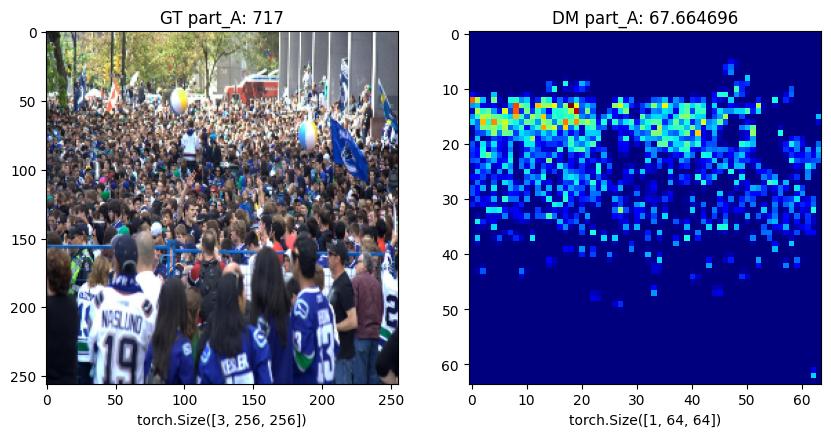

In [ ]:
for i, (img, gt_dmap, n_people) in enumerate(dataset_A): # Representasi 1 batch data
  plt.figure(figsize=(10, 5))
  plt.subplot(1,2,1)
  plt.xlabel(img.shape)
  plt.title('GT part_A: ' + str(n_people))
  plt.imshow(img.permute(1, 2, 0))

  plt.subplot(1,2,2)
  plt.xlabel(gt_dmap.shape)
  plt.title('DM part_A: ' + str(np.sum(gt_dmap.numpy())))
  plt.imshow(gt_dmap.permute(1, 2, 0), cmap="jet")
  plt.show()

  # Jika
  if i >= 0:
    break


#**4. MEMBUAT MODEL**

Menggunakan MCNN

CNN multi-kolom terdiri dari beberapa kolom CNN paralel, masing-masing memproses data masukan secara independen dan pada resolusi berbeda. Dalam arsitektur yang diusulkan, kolom pertama adalah dengan resolusi terendah (dengan ukuran kernel terbesar), dan kedalaman terendah; Kolom ke-2 memiliki resolusi yang semakin meningkat (ukuran kernel lebih kecil), dan kedalaman lebih besar, dan seterusnya.

Setiap kolom CNN belajar mengekstrak fitur yang berisi aspek berbeda dari data masukan. Setelah ekstraksi fitur, keluaran dari semua kolom CNN digabungkan dengan penggabungan. Fitur gabungan dilewatkan melalui satu lapisan konvolusional untuk menghasilkan keluaran akhir.

In [ ]:
class MC_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.column1 = nn.Sequential(
            nn.Conv2d(3, 8, 9, padding='same'), # Ch, filter, size
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 7, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 7, padding='same'),
            nn.ReLU(),
            nn.Conv2d(32, 16, 7, padding='same'),
            nn.ReLU(),
            nn.Conv2d(16, 8, 7, padding='same'),
            nn.ReLU(),
        )

        self.column2 = nn.Sequential(
            nn.Conv2d(3, 10, 7,padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 20, 5,padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(20, 40, 5,padding='same'),
            nn.ReLU(),
            nn.Conv2d(40, 20, 5,padding='same'),
            nn.ReLU(),
            nn.Conv2d(20, 10, 5,padding='same'),
            nn.ReLU(),
        )

        self.column3 = nn.Sequential(
            nn.Conv2d(3, 12, 5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(12, 24, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(24, 48, 3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(48, 24, 3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(24, 12, 3, padding='same'),
            nn.ReLU(),
        )

        # Menggabungkan ketiga column
        self.fusion_layer = nn.Sequential(
            nn.Conv2d(30, 1, 1, padding=0),
        )


    def forward(self,img_tensor):
        x1 = self.column1(img_tensor) # Hasil column1
        x2 = self.column2(img_tensor) # Hasil column2
        x3 = self.column3(img_tensor) # Hasil column3
        x = torch.cat((x1, x2, x3),1) # Digabung secara horizontal
        x = self.fusion_layer(x) # Hasil x diteruskan ke fusion_layer untuk digabungkan
        return x

In [ ]:
# Menguji model MC_CNN()

# Input acak 1 batch, 3 ch, h, w
img=torch.rand((1,3,768,1024),dtype=torch.float)
mcnn=MC_CNN()
out_dmap=mcnn(img)
print(out_dmap.shape)

torch.Size([1, 1, 192, 256])


#**5. PERSIAPAN DATA TRAINING VALIDASI DAN TESTING**

In [ ]:
# Mengatur ukuran batch dan perangkat
batch_size = 8
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Fungsi untuk memuat data pelatihan dan membuat data loader
def load_data(train_root_dir, test_root_dir):
    # Memuat data pelatihan
    init_training_set = DataLoader(train_root_dir, gt_downsample=4, shuffle=True, resize=(256, 256))

    # Split ukuran set pelatihan dan validasi
    train_size = int(0.85 * len(init_training_set)) # 85% dari dataset
    val_size = len(init_training_set) - train_size  # 15% dari dataset

    # Membuat indeks untuk subset pelatihan dan validasi
    train_indices = list(range(train_size))
    val_indices = list(range(train_size, len(init_training_set)))

    # Membuat subset dataset pelatihan dan validasi
    train_dataset = torch.utils.data.Subset(init_training_set, train_indices)
    val_dataset = torch.utils.data.Subset(init_training_set, val_indices)

    # Membuat data loader untuk pelatihan dan validasi
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Memuat set pengujian
    test_set = DataLoader(test_root_dir, gt_downsample=4, shuffle=False, resize=(256, 256))
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Memuat data untuk Part A
train_root_dir_A = "/content/drive/MyDrive/InformatikaPariwisata/dataset/ShanghaiTech/part_A/train_data"
test_root_dir_A = "/content/drive/MyDrive/InformatikaPariwisata/dataset/ShanghaiTech/part_A/test_data"
train_loader_A, val_loader_A, test_loader_A = load_data(train_root_dir_A, test_root_dir_A)

# Mencetak jumlah batch untuk Part A
print("Jumlah batch di train_loader Part A:", len(train_loader_A))
print("Jumlah batch di val_loader Part A:", len(val_loader_A))
print("Jumlah batch di test_loader Part A:", len(test_loader_A))


Jumlah batch di train_loader Part A: 12
Jumlah batch di val_loader Part A: 2
Jumlah batch di test_loader Part A: 6


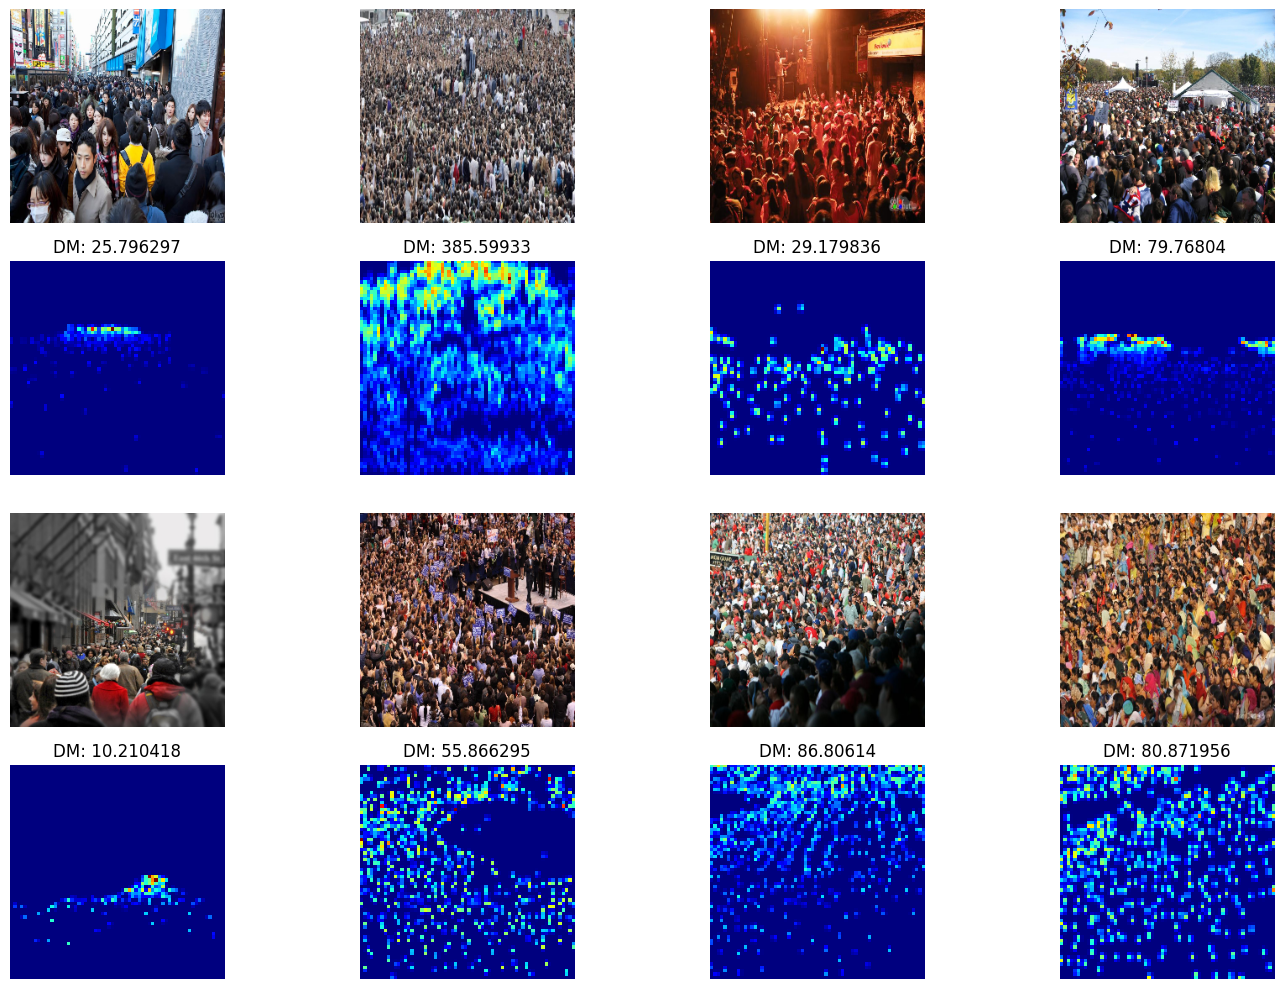

  280  2230   145   962   161   588   920   424


In [ ]:
dataiter = iter(train_loader_A)
ex_images, ex_dmaps, ex_n_people = next(dataiter)

# Fungsi plotting
def plot_corresponding_pairs(batch1, batch2, plot_map='jet'):
    num_images = batch1.shape[0]

    fig, axes = plt.subplots(int(np.ceil(num_images/2)), 4, figsize=(15, 10))

    for i in range(num_images):
        axes[int(i/4)*2, i%4].imshow(batch1[i].permute(1, 2, 0))
        axes[int(i/4)*2, i%4].axis('off')

        axes[int(i/4)*2+1, i%4].imshow(batch2[i].squeeze().detach().numpy(), cmap=plot_map)
        axes[int(i/4)*2+1, i%4].axis('off')
        axes[int(i/4)*2+1, i%4].set_title('DM: ' + str(np.sum(batch2[i].detach().numpy())))

    plt.tight_layout()
    plt.show()

# Show images and density map
plot_corresponding_pairs(ex_images, ex_dmaps)

# Print Ground truth number of people
print(' '.join('%5s' % ex_n_people[j].item() for j in range(batch_size)))


#**6. TRAINING**

* Perbedaan antara peta kepadatan dan gambar prediksi
* Perbedaan antara jumlah gambar yang diprediksi (merujuk jumlah orang) dan jumlah orang yang sebenarnya | GT

In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self, weight_dmap=0.8, weight_sum_gt=0.2):
        """
        Konstruktor untuk kelas CombinedLoss.

        Args:
            weight_dmap (float): Bobot untuk loss gambar (density map loss).
            weight_sum_gt (float): Bobot untuk loss ground truth sum.
        """
        super().__init__()
        super().__init__()  # Memanggil konstruktor dari kelas nn.Module
        self.weight_dmap = weight_dmap  # Menyimpan bobot untuk density map loss
        self.weight_sum_gt = weight_sum_gt  # Menyimpan bobot untuk ground truth sum loss
        self.img_loss = nn.MSELoss()  # Loss untuk perbandingan density map menggunakan Mean Squared Error
        self.gt_loss_mse = nn.MSELoss()  # Loss untuk perbandingan ground truth sum menggunakan Mean Squared Error
        self.gt_loss_mae = nn.L1Loss()  # Loss untuk perbandingan ground truth sum menggunakan Mean Absolute Error


    def forward(self, logits, batch_dmap, batch_gts):
         """
        Menghitung combined loss untuk input yang diberikan.

        Args:
            logits (torch.Tensor): Output prediksi dari model, yang merupakan peta kepadatan.
            batch_dmap (torch.Tensor): Ground truth density map.
            batch_gts (torch.Tensor): Ground truth count (jumlah objek).

        Returns:
            combined_loss (torch.Tensor): Nilai combined loss yang dihasilkan.
            gt_loss_mae (torch.Tensor): Nilai loss MAE untuk ground truth count.
        """
        batch_gts = batch_gts.float()  # Mengubah ground truth count ke tipe data float
        # Menghitung MSE loss antara prediksi dan ground truth density map
        img_loss = self.img_loss(logits, batch_dmap)

        # Menghitung MAE loss antara total prediksi dan ground truth count
        gt_loss_mae = self.gt_loss_mae(torch.squeeze(logits.sum(dim=(2, 3))), batch_gts)

        # Menghitung MSE loss antara total prediksi dan ground truth count (tidak digunakan dalam combined loss)
        gt_loss_mse = self.gt_loss_mse(torch.squeeze(logits.sum(dim=(2, 3))), batch_gts)

        # Menghitung combined loss dengan bobot untuk density map loss dan ground truth sum loss
        combined_loss = self.weight_dmap * img_loss + self.weight_sum_gt * gt_loss_mae

        # Mengembalikan combined loss dan gt_loss_mae (MSE loss tidak digunakan dalam return)
        return combined_loss, gt_loss_mae

In [ ]:
import torch
torch.cuda.empty_cache()


In [ ]:
num_epochs = 5
train_losses_A = []
val_losses_A = []
train_mae_losses_A = []
val_mae_losses_A = []

# Inisialisasi model, loss function, dan optimizer untuk Part A
model_A = MC_CNN().to(device)
criterion_A = CombinedLoss(0.8, 0.2)
optimizer_A = optim.Adam(model_A.parameters(), lr=1e-3)
best_val_loss_A = np.inf
best_nr_epoch_A = 0

for epoch in range(num_epochs):
    print("Epoch {}:".format(epoch))

    # fase pelatihan
    tr_loss_acc_A = 0.0
    tr_loss_mae_acc_A = 0.0

    for batch_img, batch_dmap, batch_gts in train_loader_A:
        # Masukkan data pada perangkat
        batch_img, batch_dmap, batch_gts = batch_img.to(device), batch_dmap.to(device), batch_gts.to(device)
        # Memprediksi dan mendapatkan kerugian
        logits = model_A(batch_img)
        loss, mae_loss = criterion_A(logits, batch_dmap, batch_gts)
        # Perbarui model
        optimizer_A.zero_grad()
        loss.backward()
        optimizer_A.step()

        # Terus jalankan statistik
        tr_loss_acc_A += loss.item()
        tr_loss_mae_acc_A += mae_loss.item()

    tr_loss_A = tr_loss_acc_A / len(train_loader_A.dataset)
    tr_mae_A = tr_loss_mae_acc_A / len(train_loader_A.dataset)
    print('>> TRAIN: Epoch {} | tr_loss:  {:.6f}'.format(epoch, tr_loss_A))
    print('>> TRAIN: Epoch {} | mae:      {:.6f}'.format(epoch, tr_mae_A))

    # Dapatkan hasil validasi
    with torch.inference_mode():
        val_loss_acc_A = 0.0
        val_loss_mae_acc_A = 0.0

        for batch_img_val, batch_dmap_val, batch_gts_val in val_loader_A:
            # Masukkan data pada perangkat
            batch_img_val, batch_dmap_val, batch_gts_val = batch_img_val.to(device), batch_dmap_val.to(device), batch_gts_val.to(device)

            # Memprediksi dan mendapatkan kerugian
            logits = model_A(batch_img_val)
            loss, mae_loss = criterion_A(logits, batch_dmap_val, batch_gts_val)

            # Terus jalankan statistik
            val_loss_acc_A += loss.item()
            val_loss_mae_acc_A += mae_loss.item()

    val_loss_A = val_loss_acc_A / len(val_loader_A.dataset)
    val_mae_A = val_loss_mae_acc_A / len(val_loader_A.dataset)
    print('>> VAL:   Epoch {} | val_loss: {:.6f}'.format(epoch, val_loss_A))
    print('>> VAL:   Epoch {} | mae:      {:.6f}'.format(epoch, val_mae_A))

    if val_loss_A < best_val_loss_A:
        best_val_loss_A = val_loss_A
        best_nr_epoch_A = epoch
        torch.save(model_A.state_dict(), './crowd_counting_A.pth')

    train_losses_A.append(tr_loss_A)
    train_mae_losses_A.append(tr_mae_A)
    val_losses_A.append(val_loss_A)
    val_mae_losses_A.append(val_mae_A)

print('best training MAE for Part A: ', train_mae_losses_A[best_nr_epoch_A])
print('best val MAE for Part A:      ', val_mae_losses_A[best_nr_epoch_A])


Epoch 0:


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


>> TRAIN: Epoch 0 | tr_loss:  10.883871
>> TRAIN: Epoch 0 | mae:      54.411874
>> VAL:   Epoch 0 | val_loss: 6.609670
>> VAL:   Epoch 0 | mae:      33.046273
Epoch 1:
>> TRAIN: Epoch 1 | tr_loss:  8.740271
>> TRAIN: Epoch 1 | mae:      43.694585
>> VAL:   Epoch 1 | val_loss: 6.646419
>> VAL:   Epoch 1 | mae:      33.230079
Epoch 2:
>> TRAIN: Epoch 2 | tr_loss:  8.758287
>> TRAIN: Epoch 2 | mae:      43.789594
>> VAL:   Epoch 2 | val_loss: 5.869206
>> VAL:   Epoch 2 | mae:      29.342249
Epoch 3:
>> TRAIN: Epoch 3 | tr_loss:  9.517310
>> TRAIN: Epoch 3 | mae:      47.581827
>> VAL:   Epoch 3 | val_loss: 5.741646
>> VAL:   Epoch 3 | mae:      28.704635
Epoch 4:
>> TRAIN: Epoch 4 | tr_loss:  8.245064
>> TRAIN: Epoch 4 | mae:      41.220420
>> VAL:   Epoch 4 | val_loss: 5.703135
>> VAL:   Epoch 4 | mae:      28.512152
best training MAE for Part A:  41.220420065890536
best val MAE for Part A:       28.51215171813965


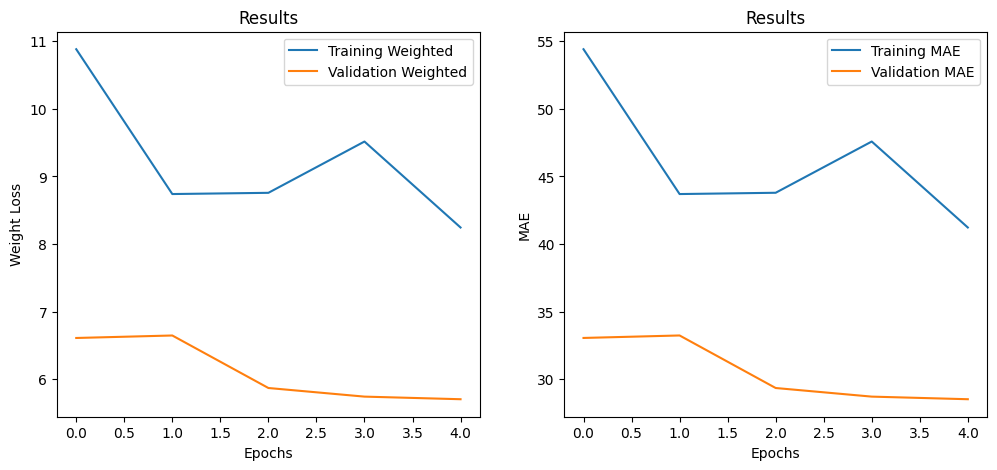

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_A, label='Training Weighted')
plt.plot(val_losses_A, label='Validation Weighted')
plt.title('Results')
plt.ylabel('Weight Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_mae_losses_A, label='Training MAE')
plt.plot(val_mae_losses_A, label='Validation MAE')
plt.title('Results')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend()

plt.show()

**BEST MODEL**

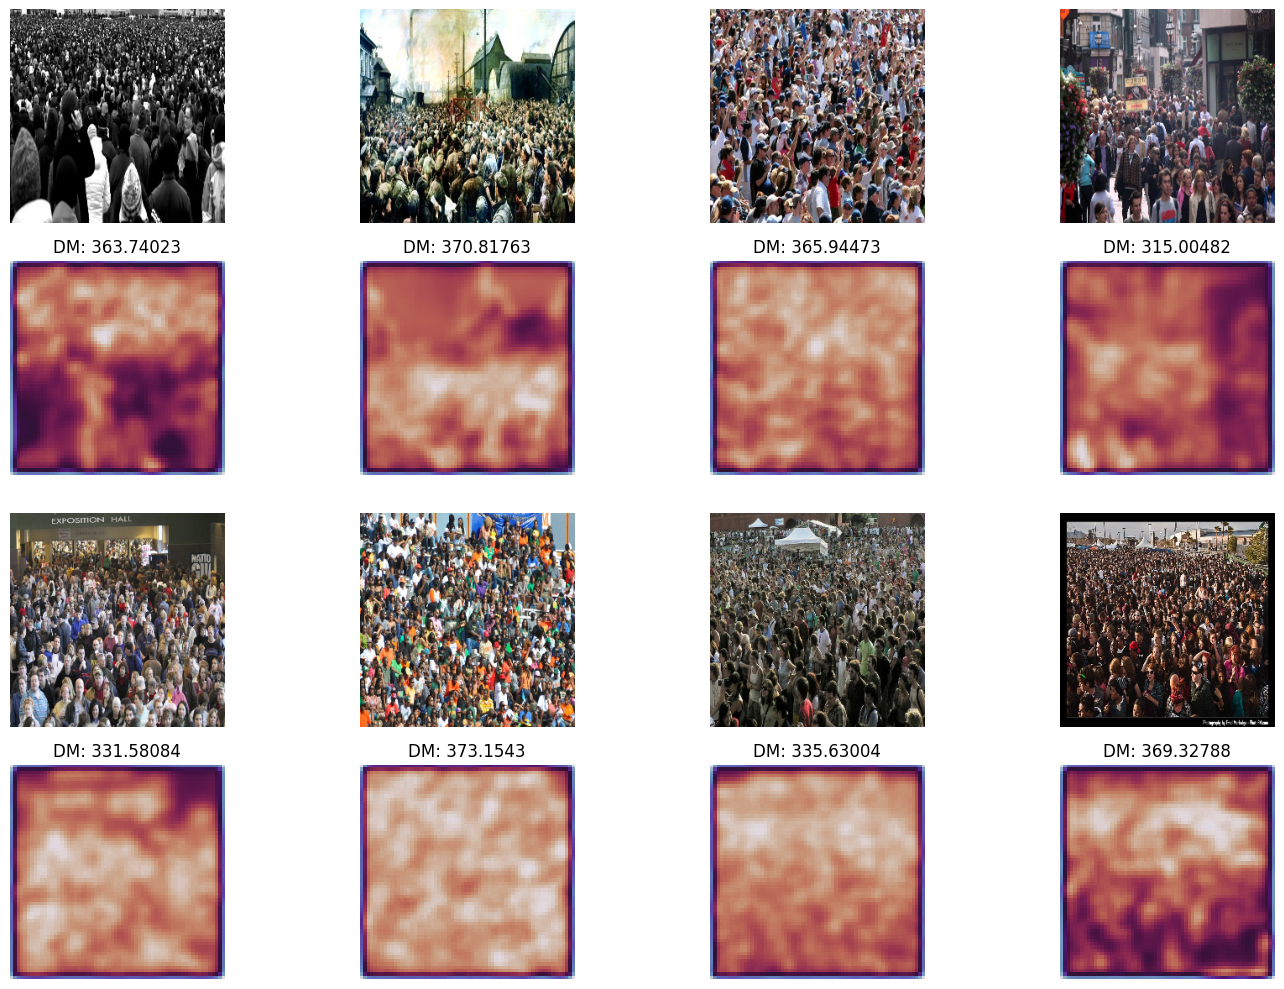

 2143   314   320   163   417   296   622   799


In [ ]:
best_model = MC_CNN().to(device)
best_model.load_state_dict(torch.load('./crowd_counting_A.pth'))
# Dapatkan beberapa gambar validasi acak
dataiter = iter(val_loader_A)
ex_images, _, ex_gts  = next(dataiter)


# Tampilkan gambar dan peta kepadatan
pred_dms = best_model(ex_images.to(device))
plot_corresponding_pairs(ex_images.cpu(), pred_dms.cpu(), 'twilight')

# Print labels
print(' '.join('%5s' % ex_gts[j].item() for j in range(batch_size)))

#**7. TESTING**

In [ ]:
# Fungsi untuk membuat prediksi biner berdasarkan threshold
def binarize_predictions(pred_dms, threshold=0.5):
    return (pred_dms > threshold).float()

# Memuat model terbaik untuk Part B
best_model_A = MC_CNN().to(device)
best_model_A.load_state_dict(torch.load('./crowd_counting_A.pth'))

criterion_mae = nn.L1Loss()
criterion_mse = nn.MSELoss()

test_loss_mae_acc_A = 0.0
test_loss_mse_acc_A = 0.0
all_pred = []
all_true = []

with torch.inference_mode():
    for batch_img, batch_dmap, batch_gts in test_loader_A:
        batch_img, batch_dmap, batch_gts = batch_img.to(device), batch_dmap.to(device), batch_gts.to(device)

        logits = best_model_A(batch_img)

        # Hitung kerugian MAE
        loss_mae = criterion_mae(torch.squeeze(logits.sum(dim=(2, 3))), batch_gts)

        # Compute MSE loss
        loss_mse = criterion_mse(torch.squeeze(logits.sum(dim=(2, 3))), batch_gts)

        # Hitung kerugian UMK
        test_loss_mae_acc_A += loss_mae.item()
        test_loss_mse_acc_A += loss_mse.item()

        # Binarkan prediksi dan kebenaran dasar
        pred_binarized = binarize_predictions(logits)
        true_binarized = binarize_predictions(batch_dmap)

        all_pred.extend(pred_binarized.cpu().numpy().flatten())
        all_true.extend(true_binarized.cpu().numpy().flatten())

# Print MAE and MSE
print('TEST: test_MAE for Part A: {:.3f}'.format(test_loss_mae_acc_A / len(test_loader_A.dataset)))
print('TEST: test_MSE for Part A: {:.3f}'.format(test_loss_mse_acc_A / len(test_loader_A.dataset)))

TEST: test_MAE for Part A: 33.798
TEST: test_MSE for Part A: 16950.946


True Negative (TN): 184187
False Positive (FP): 0
False Negative (FN): 133
True Positive (TP): 0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9992784288194444
Precision: 0.0
Recall: 0.0
F1-score: 0.0


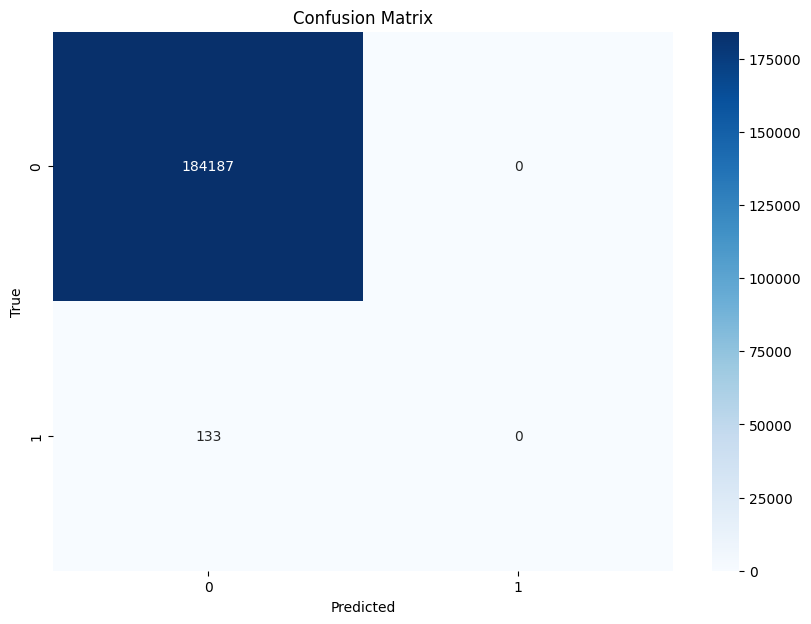

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(all_true, all_pred)
tn, fp, fn, tp = cm.ravel()

# Print TN, FP, FN, TP
print('True Negative (TN):', tn)
print('False Positive (FP):', fp)
print('False Negative (FN):', fn)
print('True Positive (TP):', tp)

# Hitung accuracy, precision, recall, f1-score
accuracy = accuracy_score(all_true, all_pred)
precision = precision_score(all_true, all_pred)
recall = recall_score(all_true, all_pred)
f1 = f1_score(all_true, all_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


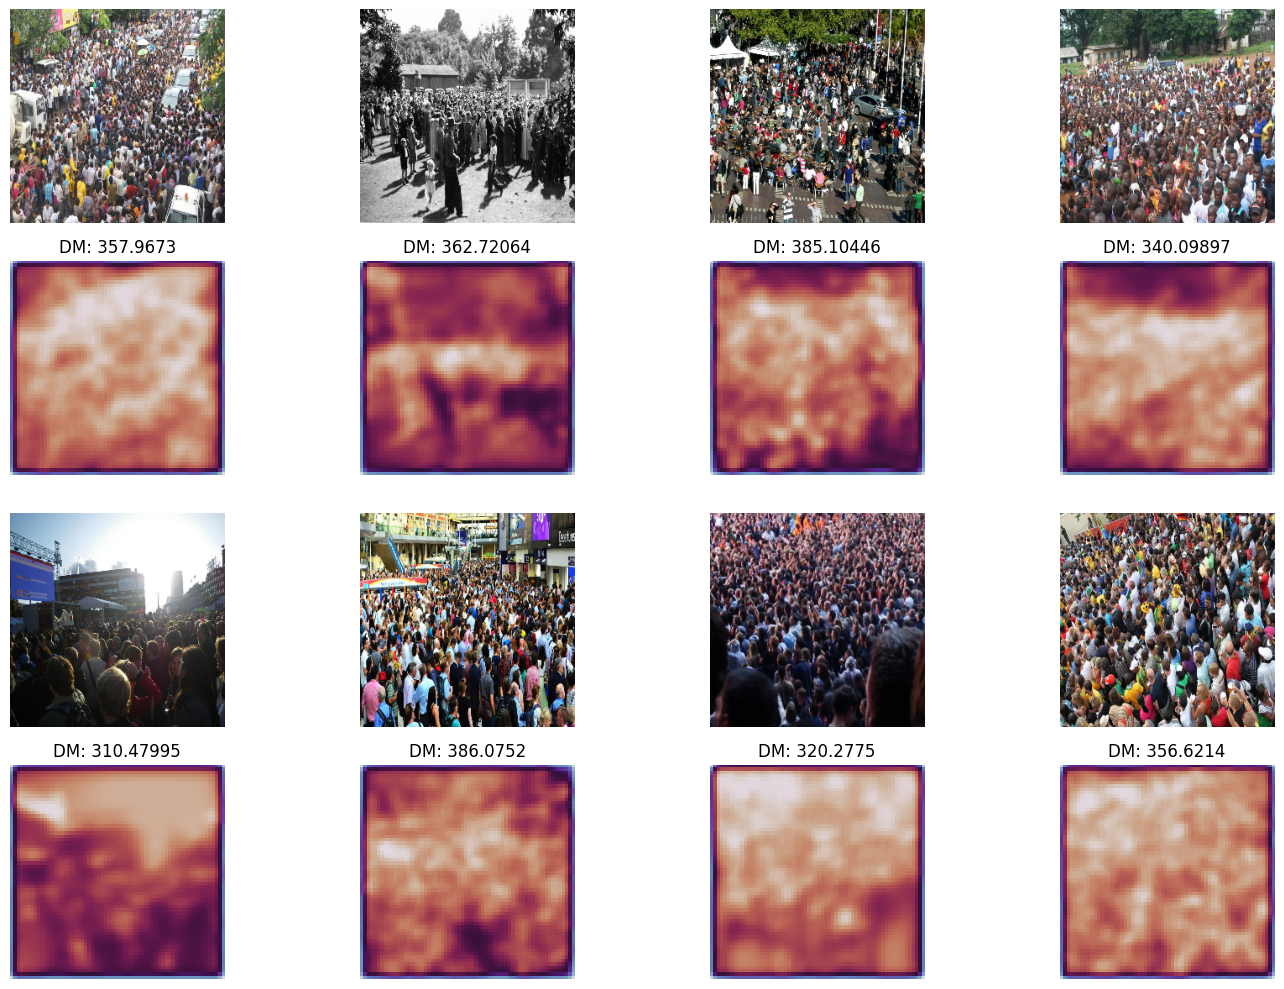

 1068   172   502   762   321   584   416   341


In [ ]:
# Mengambil beberapa gambar pengujian acak dari Part B
dataiter_A = iter(test_loader_A)
ex_images_A, _, ex_gts_A = next(dataiter_A)

# Menampilkan gambar dan peta kepadatan
pred_dms_A = best_model_A(ex_images_A.to(device))
plot_corresponding_pairs(ex_images_A.cpu(), pred_dms_A.cpu(), 'twilight')

# Menampilkan label ground truth
print(' '.join('%5s' % ex_gts_A[j].item() for j in range(len(ex_gts_A))))


#DATA BARU

In [ ]:
from torchvision import datasets

TEST: test_MAE for new test images: 23.097


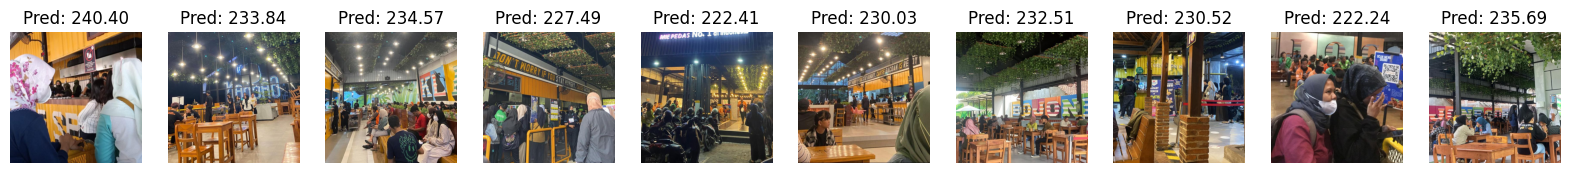

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


# Definisikan class CustomImageDataset
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith(('jpg', 'jpeg', 'png'))]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.img_files[idx]  # return image and filename

# Definisikan transformasi untuk data pengujian
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Path ke direktori gambar
img_dir = '/content/drive/MyDrive/InformatikaPariwisata/dataset/data primer/newTest'

# Membuat dataset dan DataLoader kustom
test_dataset = CustomImageDataset(img_dir=img_dir, transform=test_transform)
test_loader_new = DataLoader(
    test_dataset,
    batch_size=10,  # Sesuaikan dengan ukuran batch yang Anda inginkan
    shuffle=False
)

# Memuat model terbaik untuk Part B
best_model_A = MC_CNN().to(device)
best_model_A.load_state_dict(torch.load('./crowd_counting_A.pth'))

# Evaluasi model
criterion_mae = torch.nn.L1Loss()

test_loss_mae_acc_new = 0.0
all_pred_new = []
all_filenames_new = []

best_model_A.eval()
with torch.inference_mode():
    for batch_img, filenames in test_loader_new:
        batch_img = batch_img.to(device)

        # Prediksi model
        logits = best_model_A(batch_img)

        # Di sini kita tidak memiliki ground truth untuk gambar baru, jadi kita hanya menghitung prediksi
        predicted_counts = torch.squeeze(logits.sum(dim=(2, 3)))

        test_loss_mae_acc_new += criterion_mae(predicted_counts, torch.zeros_like(predicted_counts)).item()

        all_pred_new.extend(predicted_counts.cpu().numpy())
        all_filenames_new.extend(filenames)

# Print MAE results
print('TEST: test_MAE for new test images: {:.3f}'.format(test_loss_mae_acc_new / len(test_loader_new.dataset)))

# Tampilkan hasil prediksi
def plot_predictions(filenames, predictions, root_dir):
    fig, axes = plt.subplots(1, len(filenames), figsize=(20, 10))
    for i, filename in enumerate(filenames):
        img_path = os.path.join(root_dir, filename)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'Pred: {predictions[i]:.2f}')
        axes[i].axis('off')
    plt.show()

# Panggil fungsi untuk menampilkan prediksi
plot_predictions(all_filenames_new, all_pred_new, img_dir)


TEST: test_MAE for new test images: 23.097


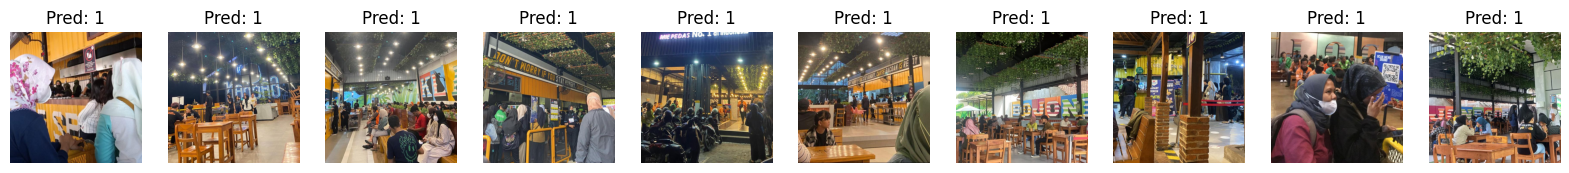

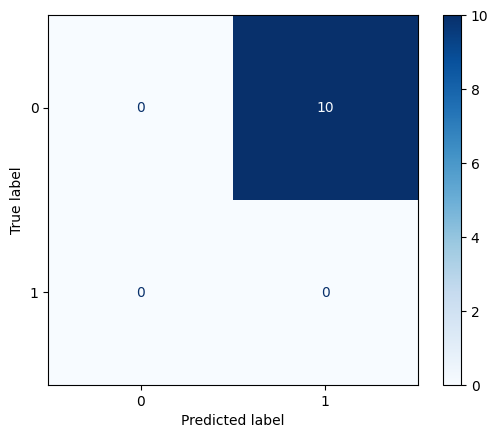

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Definisikan class CustomImageDataset
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith(('jpg', 'jpeg', 'png'))]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.img_files[idx]  # return image and filename

# Definisikan transformasi untuk data pengujian
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Path ke direktori gambar
img_dir = '/content/drive/MyDrive/InformatikaPariwisata/dataset/data primer/newTest'

# Membuat dataset dan DataLoader kustom
test_dataset = CustomImageDataset(img_dir=img_dir, transform=test_transform)
test_loader_new = DataLoader(
    test_dataset,
    batch_size=10,  # Sesuaikan dengan ukuran batch yang Anda inginkan
    shuffle=False
)

# Memuat model terbaik untuk Part B
best_model_A = MC_CNN().to(device)
best_model_A.load_state_dict(torch.load('./crowd_counting_A.pth'))

# Evaluasi model
criterion_mae = torch.nn.L1Loss()

test_loss_mae_acc_new = 0.0
all_pred_new = []
all_filenames_new = []
threshold = 0.5  # Tentukan threshold untuk binerisasi
ground_truth_class = 0  # Misalkan semua ground truth adalah 0 untuk evaluasi

best_model_A.eval()
with torch.inference_mode():
    for batch_img, filenames in test_loader_new:
        batch_img = batch_img.to(device)

        # Prediksi model
        logits = best_model_A(batch_img)

        # Di sini kita tidak memiliki ground truth untuk gambar baru, jadi kita hanya menghitung prediksi
        predicted_counts = torch.squeeze(logits.sum(dim=(2, 3)))

        test_loss_mae_acc_new += criterion_mae(predicted_counts, torch.zeros_like(predicted_counts)).item()

        # Binerisasi prediksi berdasarkan threshold
        pred_class = (predicted_counts > threshold).cpu().numpy().astype(int)

        all_pred_new.extend(pred_class)
        all_filenames_new.extend(filenames)

# Print MAE results
print('TEST: test_MAE for new test images: {:.3f}'.format(test_loss_mae_acc_new / len(test_loader_new.dataset)))

# Tampilkan hasil prediksi
def plot_predictions(filenames, predictions, root_dir):
    fig, axes = plt.subplots(1, len(filenames), figsize=(20, 10))
    for i, filename in enumerate(filenames):
        img_path = os.path.join(root_dir, filename)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'Pred: {predictions[i]}')  # Tampilkan sebagai 0 atau 1
        axes[i].axis('off')
    plt.show()

# Panggil fungsi untuk menampilkan prediksi
plot_predictions(all_filenames_new, all_pred_new, img_dir)

# Evaluasi confusion matrix
ground_truth = [ground_truth_class] * len(all_pred_new)  # Ground truth class 0 untuk semua
cm = confusion_matrix(ground_truth, all_pred_new)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()


TEST: test_MAE for new test images: 23.097


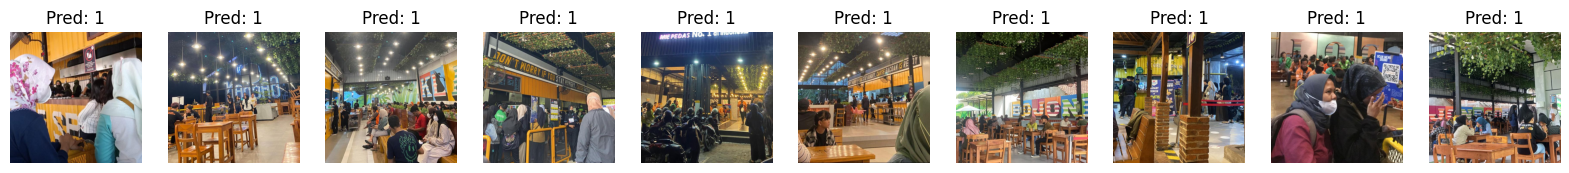

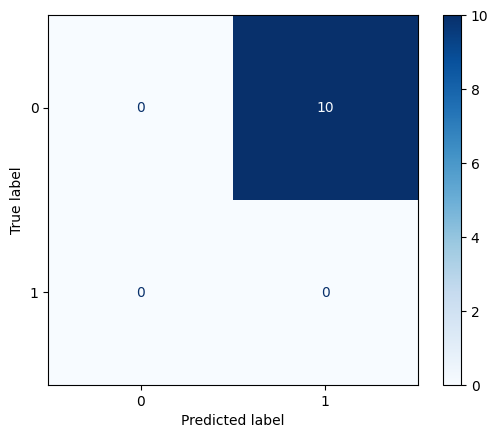

TN: 0, FP: 10, FN: 0, TP: 0
Accuracy: 0.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00


In [ ]:
# Definisikan class CustomImageDataset
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith(('jpg', 'jpeg', 'png'))]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.img_files[idx]  # return image and filename

# Definisikan transformasi untuk data pengujian
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Path ke direktori gambar
img_dir = '/content/drive/MyDrive/InformatikaPariwisata/dataset/data primer/newTest'

# Membuat dataset dan DataLoader kustom
test_dataset = CustomImageDataset(img_dir=img_dir, transform=test_transform)
test_loader_new = DataLoader(
    test_dataset,
    batch_size=10,  # Sesuaikan dengan ukuran batch yang Anda inginkan
    shuffle=False
)

# Memuat model terbaik untuk Part B
best_model_A = MC_CNN().to(device)
best_model_A.load_state_dict(torch.load('./crowd_counting_A.pth'))

# Evaluasi model
criterion_mae = torch.nn.L1Loss()

test_loss_mae_acc_new = 0.0
all_pred_new = []
all_filenames_new = []
threshold = 0.5  # Tentukan threshold untuk binerisasi
ground_truth_class = 0  # Misalkan semua ground truth adalah 0 untuk evaluasi

best_model_A.eval()
with torch.inference_mode():
    for batch_img, filenames in test_loader_new:
        batch_img = batch_img.to(device)

        # Prediksi model
        logits = best_model_A(batch_img)

        # Di sini kita tidak memiliki ground truth untuk gambar baru, jadi kita hanya menghitung prediksi
        predicted_counts = torch.squeeze(logits.sum(dim=(2, 3)))

        test_loss_mae_acc_new += criterion_mae(predicted_counts, torch.zeros_like(predicted_counts)).item()

        # Binerisasi prediksi berdasarkan threshold
        pred_class = (predicted_counts > threshold).cpu().numpy().astype(int)

        all_pred_new.extend(pred_class)
        all_filenames_new.extend(filenames)

# Print MAE results
print('TEST: test_MAE for new test images: {:.3f}'.format(test_loss_mae_acc_new / len(test_loader_new.dataset)))

# Tampilkan hasil prediksi
def plot_predictions(filenames, predictions, root_dir):
    fig, axes = plt.subplots(1, len(filenames), figsize=(20, 10))
    for i, filename in enumerate(filenames):
        img_path = os.path.join(root_dir, filename)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'Pred: {predictions[i]}')  # Tampilkan sebagai 0 atau 1
        axes[i].axis('off')
    plt.show()

# Panggil fungsi untuk menampilkan prediksi
plot_predictions(all_filenames_new, all_pred_new, img_dir)

# Evaluasi confusion matrix
ground_truth = [ground_truth_class] * len(all_pred_new)  # Ground truth class 0 untuk semua
cm = confusion_matrix(ground_truth, all_pred_new)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Hitung TN, FN, TP, FP
tn, fp, fn, tp = cm.ravel()

# Hitung metrik evaluasi
accuracy = accuracy_score(ground_truth, all_pred_new)
precision = precision_score(ground_truth, all_pred_new, zero_division=0)
recall = recall_score(ground_truth, all_pred_new, zero_division=0)
f1 = f1_score(ground_truth, all_pred_new, zero_division=0)

# Print metrik evaluasi
print(f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


#**8. EVALUASI**

Menggunakan MSE (Mean Squared Error) yaitu mengukur perbedaan antara DM yang diprediksi dan DM GT